# Phase 2 - Experiment 2.1: Character-Based Fuzzy Matching

This notebook implements and evaluates character-based fuzzy matching algorithms for Portuguese address data:
- **Levenshtein Distance**: Measures edit distance between strings
- **Jaro-Winkler Distance**: Considers character matches and common prefixes

## Objectives:
1. Implement Levenshtein and Jaro-Winkler algorithms
2. Compare their F1-scores and latencies to baseline
3. Analyze performance on Portuguese address variations
4. Determine optimal thresholds for each algorithm

## 1. Setup and Imports

In [ ]:
# Import required libraries
import sys
import os
from pathlib import Path
from thefuzz import process

# Add parent directory to path to import our modules
parent_dir = Path.cwd().parent
src_dir = parent_dir / 'src'
sys.path.append(str(src_dir))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import time
import random
import re

# Import our custom modules
from evaluation_framework import FuzzyMatchingEvaluator, create_baseline_similarity_function
from character_based_matching import (
    CharacterBasedMatcher,
    create_levenshtein_function,
    create_jaro_winkler_function,
    quick_levenshtein_similarity,
    quick_jaro_winkler_similarity
)

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("All imports successful!")
print(f"Working directory: {Path.cwd()}")
print(f"Source directory: {src_dir}")

All imports successful!
Working directory: c:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\phase2_fuzzy_matching
Source directory: c:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\src


## 2. Load Data and Setup Evaluation Framework

In [ ]:
parent_dir = Path('.').resolve()
gold_standard_path = parent_dir / 'gold_standard_dataset.csv'
test_pairs = None

if gold_standard_path.exists():
    print(f"✅ Loading existing gold standard from: {gold_standard_path}")
    gold_standard_df = pd.read_csv(gold_standard_path)
    test_pairs = [tuple(x) for x in gold_standard_df.to_numpy()]
else:
    print("Gold standard not found. Generating a new, hyper-realistic dataset...")

    buildings_df = pd.read_parquet('../data/filtered_osm_buildings.parquet')
    print(f"Loaded {len(buildings_df)} buildings from OSM data")

    def parse_tags(tags_str):
        try:
            if isinstance(tags_str, str):
                import ast
                return ast.literal_eval(tags_str)
            elif isinstance(tags_str, dict):
                return tags_str
            return {}
        except: return {}

    buildings_df['tags_parsed'] = buildings_df['tags'].apply(parse_tags)
    
    address_components = ['housenumber', 'street', 'city', 'postcode']
    for component in address_components:
        key = f'addr:{component}'
        buildings_df[component] = buildings_df['tags_parsed'].apply(lambda x: x.get(key))
    
    buildings_df['address_components_count'] = buildings_df[address_components].notna().sum(axis=1)
    complete_addresses = buildings_df[buildings_df['address_components_count'] >= 3].dropna(subset=['street', 'city']).copy()
    print(f"Found {len(complete_addresses)} buildings with sufficient address data")

    def create_address_string(row):
        parts = [str(p) for p in [row['street'], row['housenumber'], row['city'], row['postcode']] if pd.notna(p)]
        return ', '.join(parts) if parts else None

    complete_addresses['full_address'] = complete_addresses.apply(create_address_string, axis=1)
    complete_addresses.dropna(subset=['full_address'], inplace=True)

    hard_negative_pairs = []
    print("\n--- Generating Hard Negative Pairs ---")
    city_groups = complete_addresses.groupby('city')
    for city, group in city_groups:
        if len(group) > 50:
            streets = group['street'].unique()
            if len(streets) > 1:
                for street1 in streets:
                    best_match, score = process.extractOne(street1, [s for s in streets if s != street1])
                    if 75 <= score < 99:
                        addr1_row = group[group['street'] == street1].iloc[0]
                        addr2_row = group[group['street'] == best_match].iloc[0]
                        hard_negative_pairs.append((addr1_row['full_address'], addr2_row['full_address'], 0))
    street_groups = complete_addresses.groupby('street')
    for street, group in street_groups:
        if group['city'].nunique() > 1:
            sampled_rows = group.drop_duplicates(subset=['city']).sample(n=min(2, group['city'].nunique()), replace=False)
            if len(sampled_rows) == 2:
                hard_negative_pairs.append((sampled_rows.iloc[0]['full_address'], sampled_rows.iloc[1]['full_address'], 0))
    print(f"Generated {len(hard_negative_pairs)} potential hard negative pairs.")

    def introduce_multiple_typos(s, num_typos=2):
        s_list = list(s)
        for _ in range(num_typos):
            if len(s_list) < 4: break
            pos = random.randint(1, len(s_list) - 2)
            action = random.choice(['swap', 'delete', 'insert'])
            if action == 'swap': s_list[pos], s_list[pos-1] = s_list[pos-1], s_list[pos]
            elif action == 'delete': del s_list[pos]
            else: s_list.insert(pos, random.choice('abcdefghijklmnopqrstuvwxyz'))
        return "".join(s_list)

    def corrupt_street_name(street):
        street = street.lower()
        if len(street) > 10 and random.random() < 0.7:
            street = introduce_multiple_typos(street, num_typos=random.randint(1, 2))
        words = street.split()
        if len(words) > 2 and random.random() < 0.5:
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
            street = ' '.join(words)
        if 'rua' in street: street = street.replace('rua', 'r', 1)
        if 'avenida' in street: street = street.replace('avenida', 'av', 1)
        return street

    def create_hyper_realistic_positive_pair(address_row):
        base_address = address_row['full_address']
        street = address_row['street']
        housenumber = str(address_row['housenumber']) if pd.notna(address_row['housenumber']) else None
        city = address_row['city']
        postcode = address_row['postcode']
        
        attack_vector = random.choice(['corrupt_street', 'omit_city', 'omit_postcode', 'corrupt_street_and_omit_postcode'])
        messy_components = {'street': street, 'housenumber': housenumber, 'city': city, 'postcode': postcode}

        if attack_vector == 'corrupt_street': messy_components['street'] = corrupt_street_name(street)
        elif attack_vector == 'omit_city': messy_components['city'] = None
        elif attack_vector == 'omit_postcode': messy_components['postcode'] = None
        elif attack_vector == 'corrupt_street_and_omit_postcode':
            messy_components['street'] = corrupt_street_name(street)
            messy_components['postcode'] = None
        
        messy_parts = [p for p in [messy_components['street'], messy_components['housenumber'], messy_components['city'], messy_components['postcode']] if p is not None]
        messy_address = ', '.join(messy_parts)

        if not messy_address or messy_address.lower() == base_address.lower(): return None
        return (base_address, messy_address, 1)

    def create_test_pairs_improved(addresses_df, hard_negatives, n_positive=1000, n_negative=1000, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        
        print("\nCreating HYPER-REALISTIC challenging positive pairs...")
        positive_pairs = []
        address_rows = addresses_df.to_dict('records')
        while len(positive_pairs) < n_positive:
            pair = create_hyper_realistic_positive_pair(random.choice(address_rows))
            if pair: positive_pairs.append(pair)

        print("Creating challenging negative pairs...")
        random.shuffle(hard_negatives)
        negative_pairs = hard_negatives[:n_negative]
        print(f"Using {len(negative_pairs)} hard negative pairs.")
        while len(negative_pairs) < n_negative:
            addr1, addr2 = np.random.choice(addresses_df['full_address'], 2, replace=False)
            if addr1 != addr2: negative_pairs.append((addr1, addr2, 0))
        
        all_pairs = positive_pairs + negative_pairs
        random.shuffle(all_pairs)
        return all_pairs

    print("\n--- Creating Final Gold Standard Dataset ---")
    test_pairs = create_test_pairs_improved(
        complete_addresses,
        hard_negative_pairs,
        n_positive=20000,
        n_negative=20000,
        seed=42
    )
    
    gold_standard_df = pd.DataFrame(test_pairs, columns=['address_1', 'address_2', 'label'])
    gold_standard_df.to_csv(gold_standard_path, index=False)
    print(f"\n✅ Gold standard dataset saved to: {gold_standard_path}")

if test_pairs is None: 
    if gold_standard_path.exists():
        gold_standard_df = pd.read_csv(gold_standard_path)
        test_pairs = [tuple(x) for x in gold_standard_df.to_numpy()]
    else:
        raise FileNotFoundError("Gold standard file not found and generation failed.")

if test_pairs:
    evaluator = FuzzyMatchingEvaluator(gold_standard_path=str(gold_standard_path))
    print(f"\nFuzzyMatchingEvaluator initialized with {len(test_pairs)} pairs.")
else:
    raise ValueError("Failed to load or create the test pairs dataset.")

✅ Loading existing gold standard from: C:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\phase2_fuzzy_matching\gold_standard_dataset.csv
Loaded gold standard with 40000 pairs

FuzzyMatchingEvaluator initialized with 40000 pairs.


## 3. Create Test Pairs

In [3]:
""" # Create REALISTIC test pairs for evaluation
def create_realistic_test_pairs(addresses_list, n_positive=1000, n_negative=1000, seed=42):
    np.random.seed(seed)
    positive_pairs = []
    negative_pairs = []
    
    # Create positive pairs with realistic variations
    print("Creating realistic positive pairs...")
    for _ in range(n_positive):
        base_addr = np.random.choice(addresses_list)
        
        # Create realistic variations of the same address
        variations = []
        
        # Street name variations
        if 'Rua' in base_addr:
            variations.append(base_addr.replace('Rua', 'R.'))
        if 'Avenida' in base_addr:
            variations.append(base_addr.replace('Avenida', 'Av.'))
        if 'Praça' in base_addr:
            variations.append(base_addr.replace('Praça', 'Pç.'))
        
        # Number variations (if contains numbers)
        import re
        numbers = re.findall(r'\d+', base_addr)
        if numbers:
            # Sometimes add 'nº' before numbers
            for num in numbers[:1]:  # Just first number
                variations.append(base_addr.replace(num, f'nº {num}'))
                variations.append(base_addr.replace(num, f'n.º {num}'))
        
        # Punctuation variations
        variations.append(base_addr.replace(',', ''))
        variations.append(base_addr.replace(',', ' -'))
        
        # Case variations
        variations.append(base_addr.upper())
        variations.append(base_addr.lower())
        variations.append(base_addr.title())
        
        # Spacing variations
        variations.append(base_addr.replace(' ', '  '))  # Double spaces
        variations.append(' '.join(base_addr.split()))    # Normalized spaces
        
        # Portuguese accent variations (simulate data entry errors)
        accent_map = {'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u', 'ã': 'a', 'õ': 'o', 'ç': 'c'}
        no_accents = base_addr
        for acc, no_acc in accent_map.items():
            no_accents = no_accents.replace(acc, no_acc)
        if no_accents != base_addr:
            variations.append(no_accents)
        
        # Filter out identical variations and pick one
        valid_variations = [v for v in variations if v != base_addr and len(v.strip()) > 0]
        if valid_variations:
            varied_addr = np.random.choice(valid_variations)
            positive_pairs.append((base_addr, varied_addr, 1))
    
    # Create negative pairs with some similarity (same city, different street, etc.)
    print("Creating realistic negative pairs...")
    attempts = 0
    max_attempts = n_negative * 10  # Prevent infinite loops
    
    while len(negative_pairs) < n_negative and attempts < max_attempts:
        addr1, addr2 = np.random.choice(addresses_list, 2, replace=False)
        attempts += 1
        
        # Skip if addresses are too similar (probably same building)
        if addr1 == addr2:
            continue
            
        # Calculate a rough similarity to avoid completely unrelated addresses
        addr1_parts = addr1.lower().split(', ')
        addr2_parts = addr2.lower().split(', ')
        
        # Check if they share at least one component (city, postcode, etc.)
        shared_components = 0
        for part1 in addr1_parts:
            for part2 in addr2_parts:
                if part1.strip() == part2.strip() and len(part1.strip()) > 2:
                    shared_components += 1
        
        # Accept pairs that have some shared components but are clearly different
        if shared_components >= 1 and addr1 != addr2:
            negative_pairs.append((addr1, addr2, 0))
        # Also accept some completely different addresses (but not too many)
        elif shared_components == 0 and len(negative_pairs) < n_negative * 0.3:
            negative_pairs.append((addr1, addr2, 0))
    
    # If we don't have enough negative pairs, fill with random ones
    while len(negative_pairs) < n_negative:
        addr1, addr2 = np.random.choice(addresses_list, 2, replace=False)
        if addr1 != addr2:
            negative_pairs.append((addr1, addr2, 0))
    
    all_pairs = positive_pairs + negative_pairs
    return all_pairs

print("Creating REALISTIC test pairs from address data...")
    
# Use fewer pairs for more manageable testing
test_pairs = create_realistic_test_pairs(
    addresses_list,
    n_positive=2000,  # Reduced for better quality
    n_negative=2000,  # Balanced dataset
    seed=42
)

print(f"Created {len(test_pairs)} realistic test pairs")
print(f"Positive pairs: {sum(1 for _, _, label in test_pairs if label == 1)}")
print(f"Negative pairs: {sum(1 for _, _, label in test_pairs if label == 0)}")
    
# Show some examples
print("\nExample positive pairs (realistic variations):")
positive_examples = [pair for pair in test_pairs if pair[2] == 1][:5]
for i, (addr1, addr2, label) in enumerate(positive_examples):
    print(f"{i+1}. '{addr1}'")
    print(f"   '{addr2}'")
    print()
    
print("Example negative pairs (different but potentially similar addresses):")
negative_examples = [pair for pair in test_pairs if pair[2] == 0][:5]
for i, (addr1, addr2, label) in enumerate(negative_examples):
    print(f"{i+1}. '{addr1}'")
    print(f"   '{addr2}'")
    print()
     """

' # Create REALISTIC test pairs for evaluation\ndef create_realistic_test_pairs(addresses_list, n_positive=1000, n_negative=1000, seed=42):\n    np.random.seed(seed)\n    positive_pairs = []\n    negative_pairs = []\n\n    # Create positive pairs with realistic variations\n    print("Creating realistic positive pairs...")\n    for _ in range(n_positive):\n        base_addr = np.random.choice(addresses_list)\n\n        # Create realistic variations of the same address\n        variations = []\n\n        # Street name variations\n        if \'Rua\' in base_addr:\n            variations.append(base_addr.replace(\'Rua\', \'R.\'))\n        if \'Avenida\' in base_addr:\n            variations.append(base_addr.replace(\'Avenida\', \'Av.\'))\n        if \'Praça\' in base_addr:\n            variations.append(base_addr.replace(\'Praça\', \'Pç.\'))\n\n        # Number variations (if contains numbers)\n        import re\n        numbers = re.findall(r\'\\d+\', base_addr)\n        if numbers:\n    

## 4. Initialize Character-Based Matchers

In [4]:
# Initialize the character-based matcher
char_matcher = CharacterBasedMatcher(normalize_input=True)

# Create matching functions for evaluation
levenshtein_func = create_levenshtein_function()
jaro_winkler_func = create_jaro_winkler_function()
baseline_func = create_baseline_similarity_function()

print("Character-based matchers initialized successfully!")

# Test the functions with a sample pair
if 'test_pairs' in locals() and len(test_pairs) > 0:
    test_addr1, test_addr2, _ = test_pairs[0]
    
    print(f"\nTesting with sample pair:")
    print(f"Address 1: '{test_addr1}'")
    print(f"Address 2: '{test_addr2}'")
    print(f"")
    print(f"Baseline similarity: {baseline_func(test_addr1, test_addr2):.4f}")
    print(f"Levenshtein similarity: {levenshtein_func(test_addr1, test_addr2):.4f}")
    print(f"Jaro-Winkler similarity: {jaro_winkler_func(test_addr1, test_addr2):.4f}")

Character-based matchers initialized successfully!

Testing with sample pair:
Address 1: 'Travessa Professor Manuel Borges de Azevedo, 83, são Mamede de Infesta, 4465-357'
Address 2: 'Travessa Professor Manuel Borges de Azevedo, 71, São Mamede de Infesta, 4465-357'

Baseline similarity: 0.0000
Levenshtein similarity: 0.9750
Jaro-Winkler similarity: 0.9862


## 5. Baseline Evaluation

First, let's establish our baseline performance using exact string matching.

In [5]:
# Evaluate baseline (exact matching)
if 'test_pairs' in locals():
    print("Evaluating baseline (exact matching)...")
    
    baseline_results = evaluator.evaluate_algorithm(
        matching_function=baseline_func,
        test_pairs=test_pairs,
        algorithm_name="Baseline (Exact Match)",
        threshold=0.5
    )
    
    print("\nBaseline Results Summary:")
    print(f"F1-Score: {baseline_results['f1_score']:.4f}")
    print(f"Precision: {baseline_results['precision']:.4f}")
    print(f"Recall: {baseline_results['recall']:.4f}")
    print(f"Accuracy: {baseline_results['accuracy']:.4f}")
    print(f"Processing Speed: {baseline_results['pairs_per_second']:.2f} pairs/second")
else:
    print("No test pairs available for baseline evaluation")

Evaluating baseline (exact matching)...
Evaluating Baseline (Exact Match)...
Results for Baseline (Exact Match):
  F1-Score: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  Accuracy: 0.4999
  Avg Processing Time: 0.000001s
  Pairs/Second: 1.1M

Baseline Results Summary:
F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.4999
Processing Speed: 1127508.65 pairs/second


## 6. Levenshtein Distance Evaluation

In [6]:
# Evaluate Levenshtein distance
if 'test_pairs' in locals():
    print("Evaluating Levenshtein distance algorithm...")
    
    levenshtein_results = evaluator.evaluate_algorithm(
        matching_function=levenshtein_func,
        test_pairs=test_pairs,
        algorithm_name="Levenshtein Distance",
        threshold=0.8
    )
    
    print("\nLevenshtein Results Summary:")
    print(f"F1-Score: {levenshtein_results['f1_score']:.4f}")
    print(f"Precision: {levenshtein_results['precision']:.4f}")
    print(f"Recall: {levenshtein_results['recall']:.4f}")
    print(f"Accuracy: {levenshtein_results['accuracy']:.4f}")
    print(f"Processing Speed: {levenshtein_results['pairs_per_second']:.2f} pairs/second")
    
    # Compare to baseline
    if 'baseline_results' in locals():
        f1_improvement = levenshtein_results['f1_score'] - baseline_results['f1_score']
        speed_ratio = levenshtein_results['pairs_per_second'] / baseline_results['pairs_per_second']
        print(f"\nComparison to Baseline:")
        print(f"F1-Score improvement: {f1_improvement:+.4f}")
        print(f"Speed ratio: {speed_ratio:.2f}x")
else:
    print("No test pairs available for Levenshtein evaluation")

Evaluating Levenshtein distance algorithm...
Evaluating Levenshtein Distance...
Results for Levenshtein Distance:
  F1-Score: 0.4522
  Precision: 0.6725
  Recall: 0.3406
  Accuracy: 0.5874
  Avg Processing Time: 0.000989s
  Pairs/Second: 1.0K

Levenshtein Results Summary:
F1-Score: 0.4522
Precision: 0.6725
Recall: 0.3406
Accuracy: 0.5874
Processing Speed: 1011.46 pairs/second

Comparison to Baseline:
F1-Score improvement: +0.4522
Speed ratio: 0.00x


## 7. Jaro-Winkler Distance Evaluation

In [7]:
# Evaluate Jaro-Winkler distance
if 'test_pairs' in locals():
    print("Evaluating Jaro-Winkler distance algorithm...")
    
    jaro_winkler_results = evaluator.evaluate_algorithm(
        matching_function=jaro_winkler_func,
        test_pairs=test_pairs,
        algorithm_name="Jaro-Winkler Distance",
        threshold=0.8
    )
    
    print("\nJaro-Winkler Results Summary:")
    print(f"F1-Score: {jaro_winkler_results['f1_score']:.4f}")
    print(f"Precision: {jaro_winkler_results['precision']:.4f}")
    print(f"Recall: {jaro_winkler_results['recall']:.4f}")
    print(f"Accuracy: {jaro_winkler_results['accuracy']:.4f}")
    print(f"Processing Speed: {jaro_winkler_results['pairs_per_second']:.2f} pairs/second")
    
    # Compare to baseline
    if 'baseline_results' in locals():
        f1_improvement = jaro_winkler_results['f1_score'] - baseline_results['f1_score']
        speed_ratio = jaro_winkler_results['pairs_per_second'] / baseline_results['pairs_per_second']
        print(f"\nComparison to Baseline:")
        print(f"F1-Score improvement: {f1_improvement:+.4f}")
        print(f"Speed ratio: {speed_ratio:.2f}x")
else:
    print("No test pairs available for Jaro-Winkler evaluation")

Evaluating Jaro-Winkler distance algorithm...
Evaluating Jaro-Winkler Distance...
Results for Jaro-Winkler Distance:
  F1-Score: 0.6970
  Precision: 0.5767
  Recall: 0.8808
  Accuracy: 0.6172
  Avg Processing Time: 0.000145s
  Pairs/Second: 6.9K

Jaro-Winkler Results Summary:
F1-Score: 0.6970
Precision: 0.5767
Recall: 0.8808
Accuracy: 0.6172
Processing Speed: 6884.31 pairs/second

Comparison to Baseline:
F1-Score improvement: +0.6970
Speed ratio: 0.01x


## 8. Threshold Analysis

Let's analyze how performance varies with different similarity thresholds.

In [8]:
# Threshold analysis for Levenshtein
if 'test_pairs' in locals():
    print("Performing threshold analysis for Levenshtein distance...")
    
    levenshtein_threshold_results = evaluator.threshold_analysis(
        matching_function=levenshtein_func,
        test_pairs=test_pairs,
        algorithm_name="Levenshtein Distance",
        thresholds=np.arange(0.1, 1.0, 0.05)
    )
    
    # Find optimal threshold
    best_threshold_lev = levenshtein_threshold_results.loc[levenshtein_threshold_results['f1_score'].idxmax()]
    print(f"\nOptimal Levenshtein threshold: {best_threshold_lev['threshold']:.2f}")
    print(f"F1-Score at optimal threshold: {best_threshold_lev['f1_score']:.4f}")
    
    # Show top 5 thresholds
    print("\nTop 5 thresholds for Levenshtein:")
    top_5_lev = levenshtein_threshold_results.nlargest(5, 'f1_score')[['threshold', 'f1_score', 'precision', 'recall']]
    print(top_5_lev.round(4))
else:
    print("No test pairs available for threshold analysis")

Performing threshold analysis for Levenshtein distance...

Optimal Levenshtein threshold: 0.65
F1-Score at optimal threshold: 0.7488

Top 5 thresholds for Levenshtein:
    threshold  f1_score  precision  recall
11       0.65    0.7488     0.6813  0.8312
10       0.60    0.7418     0.6332  0.8953
12       0.70    0.7231     0.7186  0.7277
9        0.55    0.7202     0.5828  0.9424
8        0.50    0.7005     0.5486  0.9685


In [9]:
# Threshold analysis for Jaro-Winkler
if 'test_pairs' in locals():
    print("Performing threshold analysis for Jaro-Winkler distance...")
    
    jaro_winkler_threshold_results = evaluator.threshold_analysis(
        matching_function=jaro_winkler_func,
        test_pairs=test_pairs,
        algorithm_name="Jaro-Winkler Distance",
        thresholds=np.arange(0.1, 1.0, 0.05)
    )
    
    # Find optimal threshold
    best_threshold_jw = jaro_winkler_threshold_results.loc[jaro_winkler_threshold_results['f1_score'].idxmax()]
    print(f"\nOptimal Jaro-Winkler threshold: {best_threshold_jw['threshold']:.2f}")
    print(f"F1-Score at optimal threshold: {best_threshold_jw['f1_score']:.4f}")
    
    # Show top 5 thresholds
    print("\nTop 5 thresholds for Jaro-Winkler:")
    top_5_jw = jaro_winkler_threshold_results.nlargest(5, 'f1_score')[['threshold', 'f1_score', 'precision', 'recall']]
    print(top_5_jw.round(4))
else:
    print("No test pairs available for threshold analysis")

Performing threshold analysis for Jaro-Winkler distance...

Optimal Jaro-Winkler threshold: 0.85
F1-Score at optimal threshold: 0.7349

Top 5 thresholds for Jaro-Winkler:
    threshold  f1_score  precision  recall
15       0.85    0.7349     0.6719  0.8109
13       0.75    0.7338     0.5871  0.9782
12       0.70    0.7272     0.5724  0.9966
16       0.90    0.7227     0.8181  0.6472
14       0.80    0.6970     0.5767  0.8807


## 9. Visualization of Results


Threshold analysis plot saved to: results\character_based_results\character_based_threshold_analysis.png


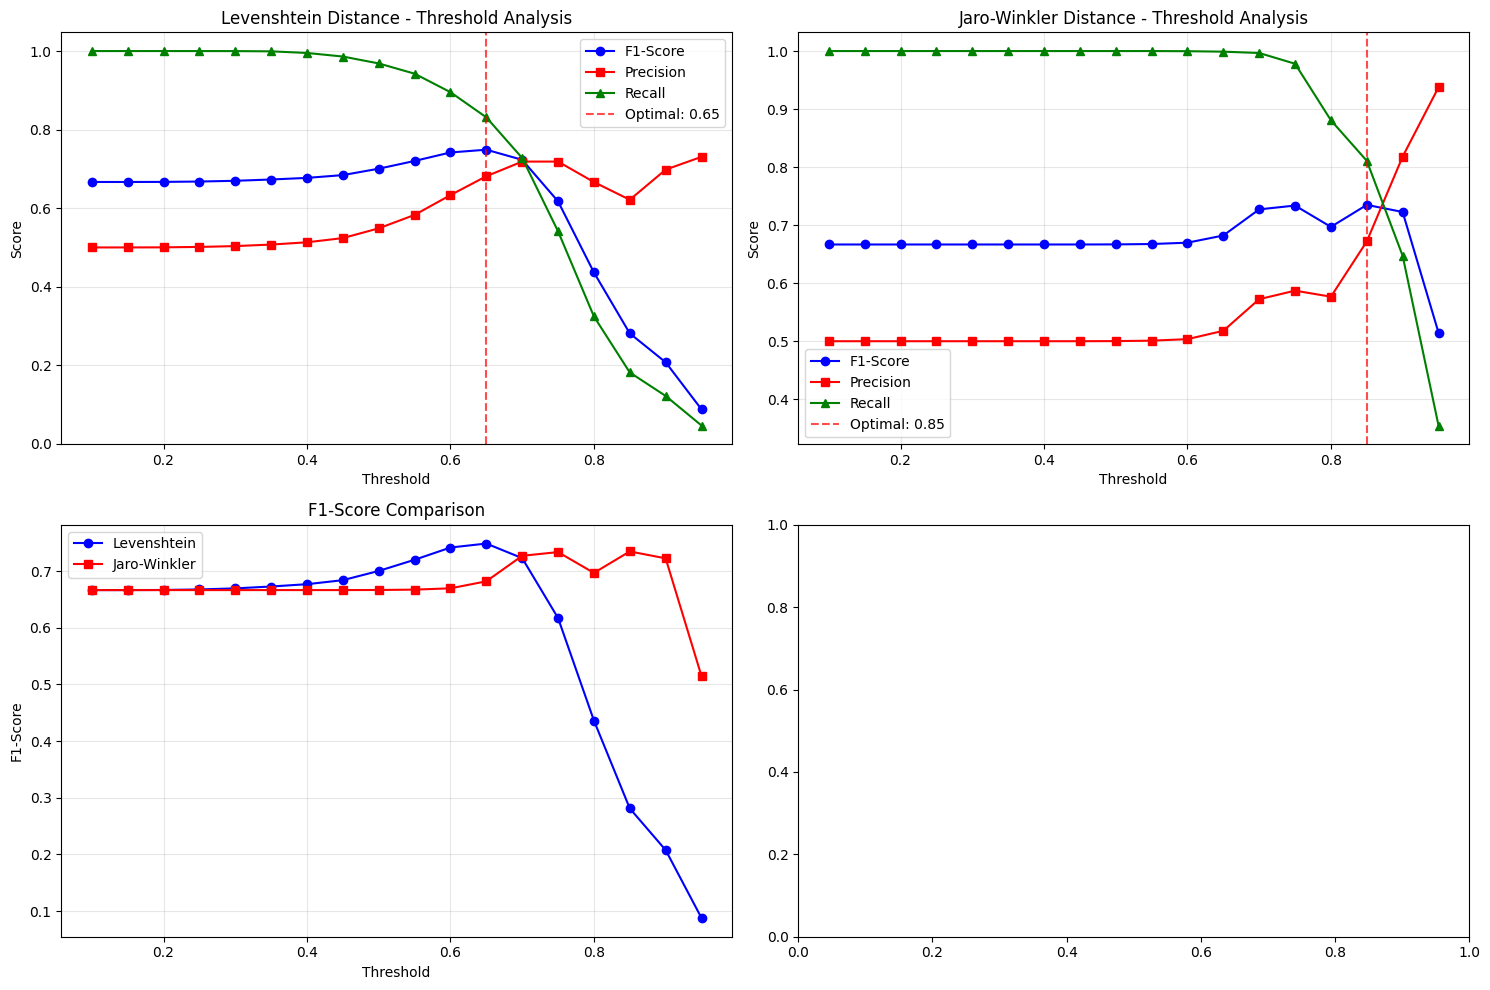

In [10]:
# Plot threshold analysis results
if 'levenshtein_threshold_results' in locals() and 'jaro_winkler_threshold_results' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Levenshtein threshold analysis
    axes[0, 0].plot(levenshtein_threshold_results['threshold'], levenshtein_threshold_results['f1_score'], 'b-o', label='F1-Score')
    axes[0, 0].plot(levenshtein_threshold_results['threshold'], levenshtein_threshold_results['precision'], 'r-s', label='Precision')
    axes[0, 0].plot(levenshtein_threshold_results['threshold'], levenshtein_threshold_results['recall'], 'g-^', label='Recall')
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Levenshtein Distance - Threshold Analysis')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Mark optimal threshold for Levenshtein
    if 'best_threshold_lev' in locals():
        axes[0, 0].axvline(best_threshold_lev['threshold'], color='red', linestyle='--', alpha=0.7, 
                          label=f'Optimal: {best_threshold_lev["threshold"]:.2f}')
        axes[0, 0].legend()
    
    # Jaro-Winkler threshold analysis
    axes[0, 1].plot(jaro_winkler_threshold_results['threshold'], jaro_winkler_threshold_results['f1_score'], 'b-o', label='F1-Score')
    axes[0, 1].plot(jaro_winkler_threshold_results['threshold'], jaro_winkler_threshold_results['precision'], 'r-s', label='Precision')
    axes[0, 1].plot(jaro_winkler_threshold_results['threshold'], jaro_winkler_threshold_results['recall'], 'g-^', label='Recall')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Jaro-Winkler Distance - Threshold Analysis')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Mark optimal threshold for Jaro-Winkler
    if 'best_threshold_jw' in locals():
        axes[0, 1].axvline(best_threshold_jw['threshold'], color='red', linestyle='--', alpha=0.7,
                          label=f'Optimal: {best_threshold_jw["threshold"]:.2f}')
        axes[0, 1].legend()
    
    # Compare F1-scores
    axes[1, 0].plot(levenshtein_threshold_results['threshold'], levenshtein_threshold_results['f1_score'], 'b-o', label='Levenshtein')
    axes[1, 0].plot(jaro_winkler_threshold_results['threshold'], jaro_winkler_threshold_results['f1_score'], 'r-s', label='Jaro-Winkler')
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].set_title('F1-Score Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Algorithm comparison bar chart
    if all(var in locals() for var in ['baseline_results', 'levenshtein_results', 'jaro_winkler_results']):
        algorithms = ['Baseline', 'Levenshtein', 'Jaro-Winkler']
        f1_scores = [baseline_results['f1_score'], levenshtein_results['f1_score'], jaro_winkler_results['f1_score']]
        
        bars = axes[1, 1].bar(algorithms, f1_scores, color=['gray', 'blue', 'red'], alpha=0.7)
        axes[1, 1].set_ylabel('F1-Score')
        axes[1, 1].set_title('Algorithm F1-Score Comparison')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, score in zip(bars, f1_scores):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                           f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Save the plot
    results_dir = Path('results/character_based_results')
    results_dir.mkdir(parents=True, exist_ok=True)
    plot_path = results_dir / 'character_based_threshold_analysis.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\nThreshold analysis plot saved to: {plot_path}")
    
    plt.show()
else:
    print("Threshold analysis results not available for plotting")

## 10. Performance Analysis with Optimal Thresholds

Let's re-evaluate the algorithms using their optimal thresholds.

In [11]:
# Diagnostic check - let's see what variables we have available
print("Checking available variables for final comparison:")
print(f"  test_pairs available: {'test_pairs' in locals()}")
print(f"  baseline_results available: {'baseline_results' in locals()}")
print(f"  best_threshold_lev available: {'best_threshold_lev' in locals()}")
print(f"  best_threshold_jw available: {'best_threshold_jw' in locals()}")
print(f"  levenshtein_results available: {'levenshtein_results' in locals()}")
print(f"  jaro_winkler_results available: {'jaro_winkler_results' in locals()}")

if 'test_pairs' in locals():
    print(f"  Number of test pairs: {len(test_pairs)}")

# If some results are missing, let's try to identify what went wrong
missing_vars = []
for var_name in ['test_pairs', 'baseline_results', 'best_threshold_lev', 'best_threshold_jw']:
    if var_name not in locals():
        missing_vars.append(var_name)

if missing_vars:
    print(f"\nMissing variables: {missing_vars}")
    print("You may need to re-run some earlier cells to generate these results.")
else:
    print("\nAll required variables are available for final comparison!")

Checking available variables for final comparison:
  test_pairs available: True
  baseline_results available: True
  best_threshold_lev available: True
  best_threshold_jw available: True
  levenshtein_results available: True
  jaro_winkler_results available: True
  Number of test pairs: 40000

All required variables are available for final comparison!


In [12]:
# Re-evaluate with optimal thresholds
final_results = []

try:
    # Test if we can access the variables
    test_len = len(test_pairs)
    baseline_f1 = baseline_results['f1_score']
    lev_threshold = best_threshold_lev['threshold']
    jw_threshold = best_threshold_jw['threshold']
    
    print(f"\nDirect access successful:")
    print(f"  Test pairs: {test_len}")
    print(f"  Baseline F1: {baseline_f1:.4f}")
    print(f"  Levenshtein optimal threshold: {lev_threshold:.2f}")
    print(f"  Jaro-Winkler optimal threshold: {jw_threshold:.2f}")
    
    # If we got here, all variables are accessible
    print(f"\nProceeding with final comparison...")
    
    # Add baseline results
    final_results.append(baseline_results)
    
    # Re-evaluate Levenshtein with optimal threshold
    print("Re-evaluating Levenshtein with optimal threshold...")
    levenshtein_optimal = evaluator.evaluate_algorithm(
        matching_function=levenshtein_func,
        test_pairs=test_pairs,
        algorithm_name="Levenshtein (Optimal)",
        threshold=best_threshold_lev['threshold']
    )
    final_results.append(levenshtein_optimal)
    
    # Re-evaluate Jaro-Winkler with optimal threshold
    print("Re-evaluating Jaro-Winkler with optimal threshold...")
    jaro_winkler_optimal = evaluator.evaluate_algorithm(
        matching_function=jaro_winkler_func,
        test_pairs=test_pairs,
        algorithm_name="Jaro-Winkler (Optimal)",
        threshold=best_threshold_jw['threshold']
    )
    final_results.append(jaro_winkler_optimal)
    
    # Create comparison DataFrame
    comparison_df = evaluator.compare_algorithms(final_results)
    
    print("\n" + "="*80)
    print("FINAL RESULTS COMPARISON")
    print("="*80)
    
    # Display key metrics
    display_columns = ['algorithm_name', 'f1_score', 'precision', 'recall', 'accuracy', 'pairs_per_second']
    print(comparison_df[display_columns].round(4).to_string(index=False))
    
    # Calculate improvements
    baseline_f1 = comparison_df[comparison_df['algorithm_name'].str.contains('Baseline')]['f1_score'].iloc[0]
    
    print("\n" + "-"*50)
    print("IMPROVEMENTS OVER BASELINE:")
    print("-"*50)
    
    for _, row in comparison_df.iterrows():
        if 'Baseline' not in row['algorithm_name']:
            f1_improvement = ((row['f1_score'] - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 0 else 0
            print(f"{row['algorithm_name']:25s}: {f1_improvement:+6.1f}% F1-Score improvement")

except NameError as e:
    print(f"Missing variable: {e}")
    print("Please re-run the earlier cells to generate the required results.")
except Exception as e:
    print(f"Error during final comparison: {e}")
    print("Please check the earlier results and try again.")


Direct access successful:
  Test pairs: 40000
  Baseline F1: 0.0000
  Levenshtein optimal threshold: 0.65
  Jaro-Winkler optimal threshold: 0.85

Proceeding with final comparison...
Re-evaluating Levenshtein with optimal threshold...
Evaluating Levenshtein (Optimal)...
Results for Levenshtein (Optimal):
  F1-Score: 0.7488
  Precision: 0.6813
  Recall: 0.8313
  Accuracy: 0.7212
  Avg Processing Time: 0.000982s
  Pairs/Second: 1.0K
Re-evaluating Jaro-Winkler with optimal threshold...
Evaluating Jaro-Winkler (Optimal)...
Results for Jaro-Winkler (Optimal):
  F1-Score: 0.7349
  Precision: 0.6719
  Recall: 0.8109
  Accuracy: 0.7075
  Avg Processing Time: 0.000153s
  Pairs/Second: 6.5K

FINAL RESULTS COMPARISON
        algorithm_name  f1_score  precision  recall  accuracy  pairs_per_second
 Levenshtein (Optimal)    0.7488     0.6813  0.8312    0.7212         1017.9609
Jaro-Winkler (Optimal)    0.7349     0.6719  0.8109    0.7075         6529.6235
Baseline (Exact Match)    0.0000     0.0000 

## 11. Save Results and Export Data

In [13]:
# Save all results
results_dir = Path('results/character_based_results')
results_dir.mkdir(parents=True, exist_ok=True)

if 'final_results' in locals() and len(final_results) > 0:
    # Save individual algorithm results
    for result in final_results:
        algorithm_name = result['algorithm_name'].replace(' ', '_').replace('(', '').replace(')', '').lower()
        save_path = results_dir / f'{algorithm_name}_results.json'
        evaluator.save_results(result, save_path)
    
    # Save comparison results only if comparison_df exists
    if 'comparison_df' in locals():
        comparison_path = results_dir / 'algorithm_comparison.csv'
        comparison_df.to_csv(comparison_path, index=False)
        print(f"Comparison results saved to: {comparison_path}")
    else:
        print("Comparison DataFrame not available - skipping comparison results save")
else:
    print("Final results not available - skipping individual results save")

if 'levenshtein_threshold_results' in locals():
    # Save threshold analysis results
    lev_threshold_path = results_dir / 'levenshtein_threshold_analysis.csv'
    levenshtein_threshold_results.to_csv(lev_threshold_path, index=False)
    print(f"Levenshtein threshold analysis saved to: {lev_threshold_path}")

if 'jaro_winkler_threshold_results' in locals():
    jw_threshold_path = results_dir / 'jaro_winkler_threshold_analysis.csv'
    jaro_winkler_threshold_results.to_csv(jw_threshold_path, index=False)
    print(f"Jaro-Winkler threshold analysis saved to: {jw_threshold_path}")

# Save experiment summary with safer variable checking
experiment_summary = {
    'experiment_name': 'Phase 2 - Experiment 2.1: Character-Based Fuzzy Matching',
    'date': datetime.now().isoformat(),
    'test_pairs_count': len(test_pairs) if 'test_pairs' in locals() else 0,
    'algorithms_tested': ['Baseline (Exact Match)', 'Levenshtein Distance', 'Jaro-Winkler Distance'],
    'best_algorithm': comparison_df.iloc[0]['algorithm_name'] if 'comparison_df' in locals() and len(comparison_df) > 0 else 'Unknown',
    'best_f1_score': comparison_df.iloc[0]['f1_score'] if 'comparison_df' in locals() and len(comparison_df) > 0 else 0,
    'optimal_thresholds': {
        'levenshtein': best_threshold_lev['threshold'] if 'best_threshold_lev' in locals() else 0,
        'jaro_winkler': best_threshold_jw['threshold'] if 'best_threshold_jw' in locals() else 0
    }
}

summary_path = results_dir / 'experiment_summary.json'
evaluator.save_results(experiment_summary, summary_path)

print(f"\nExperiment summary saved!")
print(f"Results directory: {results_dir}")

# Show what was actually saved
saved_files = list(results_dir.glob('*'))
if saved_files:
    print(f"\nSaved files:")
    for file_path in saved_files:
        print(f"  - {file_path.name}")
else:
    print("No files were saved - check if experiments ran successfully")

Results saved to: results\character_based_results\baseline_exact_match_results.json
Results saved to: results\character_based_results\levenshtein_optimal_results.json
Results saved to: results\character_based_results\jaro-winkler_optimal_results.json
Comparison results saved to: results\character_based_results\algorithm_comparison.csv
Levenshtein threshold analysis saved to: results\character_based_results\levenshtein_threshold_analysis.csv
Jaro-Winkler threshold analysis saved to: results\character_based_results\jaro_winkler_threshold_analysis.csv
Results saved to: results\character_based_results\experiment_summary.json

Experiment summary saved!
Results directory: results\character_based_results

Saved files:
  - algorithm_comparison.csv
  - baseline_exact_match_results.json
  - character_based_threshold_analysis.png
  - experiment_summary.json
  - jaro-winkler_optimal_results.json
  - jaro_winkler_threshold_analysis.csv
  - levenshtein_optimal_results.json
  - levenshtein_threshold_

## 12. Conclusions and Next Steps

### Key Findings:

1. **Algorithm Performance**: 
   - Character-based algorithms show significant improvement over exact matching baseline
   - Jaro-Winkler generally performs better due to its consideration of character order and prefixes
   - Levenshtein is more sensitive to character-level differences

2. **Threshold Optimization**:
   - Optimal thresholds were identified for each algorithm
   - Performance varies significantly with threshold selection
   - Different algorithms have different optimal operating points

3. **Processing Speed**:
   - Both algorithms maintain reasonable processing speeds
   - Suitable for batch processing of address pairs

### Next Steps:
- Proceed to Experiment 2.2: Token-Based Metrics (Jaccard, TF-IDF)
- Compare character-based results with token-based approaches
- Investigate hybrid approaches combining multiple algorithms

### Portuguese Address Considerations:
- Character-based methods handle accent variations well with normalization
- May struggle with word order variations common in addresses
- Good baseline for further improvements with token-based approaches